① 使用以下三阶多项式来生成训练和测试数据的标签：$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

② 这个式子只是一个三次多项式，并不是哪个函数的泰勒展开。

In [11]:
import math
import numpy as np
import torch
from torch import nn

from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [12]:
max_degree = 20 # 特征为20就是每一个样本是一个[20,1]的tensor
n_train, n_test = 100, 100 # 100个测试样本、100验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 真实w

# 随机生成训练集和测试集的x （features）
features = np.random.normal(size=(n_train+n_test,1))
print(features)
print(features.shape)

np.random.shuffle(features) # 打乱
print(np.arange(max_degree))
print(np.arange(max_degree).reshape(1,-1))
print(np.power([[10,20]],[[1,2]]))

# 对各个维的特征取0次方、1次方、2次方...19次方  
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) 
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # i次方的特征除以(i+1)阶乘
labels = np.dot(poly_features,true_w) # 根据多项式生成y，即生成真实的labels
labels += np.random.normal(scale=0.1,size=labels.shape) # 对真实labels加噪音进去

[[ 1.35965656e+00]
 [ 5.68981098e-01]
 [-5.80980408e-01]
 [-6.88032128e-01]
 [-4.31662814e-01]
 [ 4.21866079e-01]
 [-1.84940047e-01]
 [-1.00550737e+00]
 [-7.55279695e-01]
 [ 9.59097956e-01]
 [ 1.15990389e+00]
 [-7.14110636e-01]
 [ 1.24987862e-01]
 [-1.43867915e-01]
 [ 1.14118851e+00]
 [-1.77640511e-01]
 [ 1.91320252e-01]
 [ 6.09747397e-01]
 [-1.61019168e+00]
 [ 6.94533059e-01]
 [ 3.41906446e-01]
 [ 6.96648966e-01]
 [ 2.58865876e-01]
 [ 5.65925338e-02]
 [-1.58133512e+00]
 [ 1.61914675e+00]
 [ 2.37411819e-01]
 [-1.56976724e+00]
 [-1.74483041e+00]
 [ 9.16307429e-01]
 [ 1.66475510e+00]
 [ 9.69720996e-01]
 [ 3.67139982e-02]
 [-6.20092877e-01]
 [-5.92541516e-02]
 [-1.18780358e+00]
 [ 1.08201980e-02]
 [ 8.25443284e-02]
 [-3.24370316e-02]
 [ 1.12439208e+00]
 [-4.39460414e-01]
 [-8.90403973e-01]
 [-6.16800744e-01]
 [ 3.11949588e-01]
 [ 9.53478284e-01]
 [-3.22736827e-01]
 [-1.63242715e+00]
 [-3.84533868e-01]
 [-1.52794785e+00]
 [-1.61469131e-01]
 [-5.13197459e-01]
 [-1.51236637e+00]
 [-1.9030695

### 数据处理

In [13]:
# 将列表 [true_w, features, poly_features, labels] 中的每一个元素都转换为 torch.float32 类型的张量（torch.tensor），并分别赋值回原变量名
true_w, features, poly_features, labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w, features, poly_features, labels]]           

# 将数据集拆分成特征和标签两个部分，然后用 TensorDataset 包装，才能用 DataLoader 加载


In [14]:
# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    loss_sum = 0
    num_samples = 0
    for X, y in data_iter: # 从迭代器中拿出对应特征和标签
        out = net(X)
        y = y.reshape(out.shape) # 将真实标签改为网络输出标签的形式，统一形式
        l = loss(out, y) # 计算网络输出的预测值与真实值之间的损失差值
        loss_sum += l.sum()
        num_samples += y.numel()
    return loss_sum / num_samples # 返回数据集的平均损失

In [15]:
# 定义训练函数
def train(train_data, test_data, num_epochs=400):
    loss = nn.MSELoss()
    # train_data 是 TensorDataset
    # train_data.tensors[0] 是第一个特征张量，shape[-1] 就是特征的维度。
    input_shape = train_data.tensors[0].shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 单层线性回归
    batch_size = min(10, train_data.tensors[0].shape[0])
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True, num_workers=4) 
    test_iter = data.DataLoader(test_data, batch_size, shuffle=True, num_workers=4)   
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    loss_list = []      # 新增：用于保存loss
    epoch_list = []     # 新增：用于保存epoch编号
    
    for epoch in range(num_epochs):
        for X, y in train_iter:  # 从DataLoader里面一次一次把所有数据拿出来
            l = loss(net(X),y) # net(X) 为计算出来的线性回归的预测值
            trainer.zero_grad() # 梯度清零
            l.backward()
            trainer.step()  # SGD优化器优化模型
        if epoch == 0 or (epoch + 1) % 20 == 0:
            loss_num = evaluate_loss(net, test_iter, loss)
            print(f'epoch{epoch+1},loss{loss_num:f}')
            loss_list.append(loss_num.item())         # 保存loss
            epoch_list.append(epoch + 1)       # 保存epoch编号

    print('weight',net[0].weight.data.numpy()) # 训练完后打印，打印最终学到的weight值  


    
    # 新增：画图
    plt.plot(epoch_list, loss_list, marker='o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss Every 20 Epochs')
    plt.show()

epoch1,loss6.321721
epoch20,loss5.184893
epoch40,loss5.163370
epoch60,loss5.116058
epoch80,loss5.028250
epoch100,loss5.260038
weight [[ 3.1838198  -0.0529893  -0.29508245  0.59344316]]


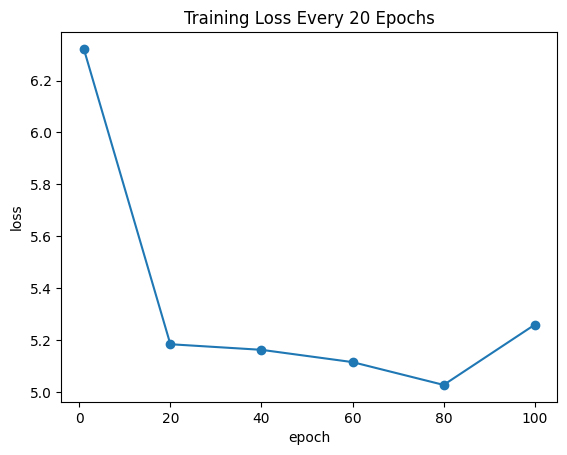

In [16]:
# 三阶多项式函数拟合(正态)
train_features = poly_features[:n_train, :4]
test_features = poly_features[n_train:, :4]
train_labels = labels[:n_train]
test_labels = labels[n_train:]
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train(train_dataset, test_dataset, num_epochs=100)  # 最后返回的weight值和公式真实weight值很接近       

epoch1,loss7.532314
epoch20,loss5.985425
epoch40,loss5.874852
epoch60,loss5.859132
epoch80,loss5.815883
epoch100,loss5.832236
weight [[3.0812325  0.38485596]]


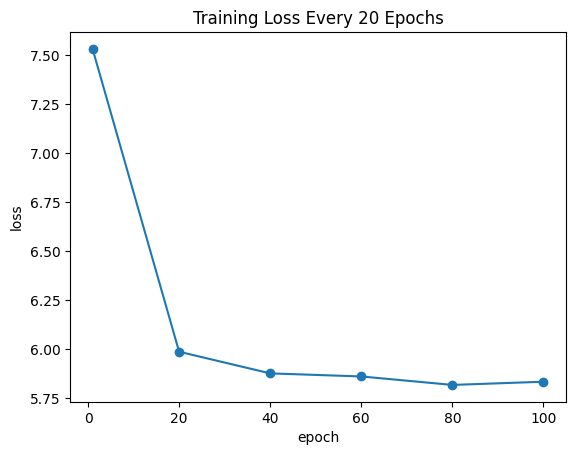

In [17]:
# 一阶多项式函数拟合(欠拟合)
# 这里相当于用一阶多项式拟合真实的三阶多项式，欠拟合了，损失很高，根本就没降
train_features = poly_features[:n_train, :2]
test_features = poly_features[n_train:, :2]
train_labels = labels[:n_train]
test_labels = labels[n_train:]
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train(train_dataset, test_dataset, num_epochs=100)  

epoch1,loss7.240668
epoch20,loss5.562479
epoch40,loss5.201078
epoch60,loss5.246445
epoch80,loss5.444914
epoch100,loss5.209358
weight [[ 3.2186670e+00  1.8092336e-01 -3.2942531e-01  4.5200089e-01
  -2.6096594e-01 -6.8887636e-02  3.0949423e-03  1.5080297e-01
   5.8938374e-05  1.5404913e-01  2.0552626e-01  7.6900400e-02
   3.6409356e-02 -1.1548037e-01  1.1557520e-01  2.1226507e-01
  -1.4526543e-01  1.3776389e-01  1.5919590e-01  2.7590275e-02]]


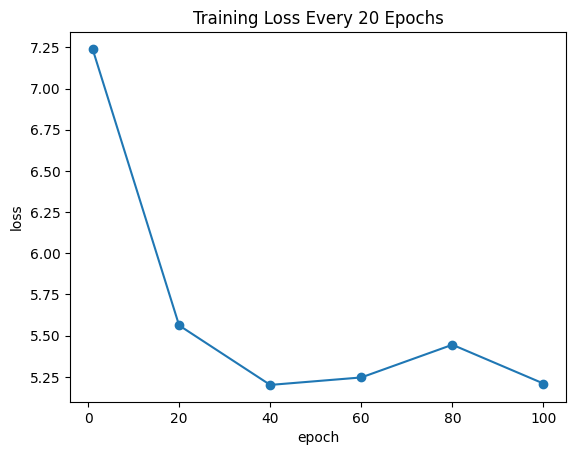

In [18]:
# 十九阶多项式函数拟合(过拟合)
# 这里相当于用十九阶多项式拟合真实的三阶多项式，过拟合了
train_features = poly_features[:n_train, :]
test_features = poly_features[n_train:, :]
train_labels = labels[:n_train]
test_labels = labels[n_train:]
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)
train(train_dataset, test_dataset, num_epochs=100)  